In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/My\ Drive/Nottingham /content

In [ ]:
!cp -r /content/drive/My\ Drive/midi /content

In [ ]:
%matplotlib inline
import os
import sys
import random
import math
sys.path.append('midi')
 
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [ ]:
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

# Data Loader

In [ ]:
import numpy as np
import torch
import torch.utils.data as data
 
 
def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll
 
 
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll
 
    return padded_piano_roll
 
 
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        # print("piano_roll",piano_roll.shape)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        # print("input_sequence",input_sequence.shape)
        ground_truth_sequence = piano_roll[:, 1:]
        # print("ground_truth",ground_truth_sequence.shape)
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        # print("input_sequence_padded",input_sequence_padded.shape)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
        # print("ground_sequence_padded",ground_truth_sequence_padded.shape)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )
 
    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)
 
    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)
 
    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)
 
    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)
 
    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [ ]:
trainset = NotesGenerationDataset('Nottingham/train/', longest_sequence_length=None)
 
trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
valset = NotesGenerationDataset('Nottingham/valid/', longest_sequence_length=None)
 
valset_loader = data.DataLoader(valset, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
a = next(iter(trainset_loader))
print(a[0].shape, a[1].shape, a[2].shape)
a[2]

torch.Size([8, 1491, 88]) torch.Size([8, 1491, 88]) torch.Size([8, 1])


tensor([[214],
        [604],
        [214],
        [214],
        [213],
        [266],
        [214],
        [214]])

## RNN Model

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]
        # print("input_sequences",input_sequences.shape)
        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        # print("outputs_drop",outputs_drop.shape)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        # print("logits_per",logits.shape)
        logits = logits.transpose(0, 1).contiguous()
        # print("logits_trans",logits.shape)
        
        neg_logits = (1 - logits)
        # print("neg_logits",neg_logits.shape)
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        # print("binary_logits",binary_logits.shape)
        logits_flatten = binary_logits.view(-1, 2)
        # print("logits_flatten",logits_flatten.shape)
        return logits_flatten, hidden

In [ ]:
model = RNN(input_size=88, hidden_size=512, num_classes=88)
 
criterion = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss()

In [ ]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0
 
    for batch in valset_loader:
 
        post_processed_batch_tuple = post_process_sequence_batch(batch)
 
        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
 
        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
 
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
 
        logits, _ = model(input_sequences_batch_var, sequences_lengths)
        # print("logits",logits.shape)
 
        loss = criterion_val(logits, output_sequences_batch_var)
 
        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)
 
    return full_val_loss / (overall_sequence_length * 88)

In [ ]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [ ]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1
 
            post_processed_batch_tuple = post_process_sequence_batch(batch)
 
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
 
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
 
            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
 
            optimizer.zero_grad()
 
            logits, _ = model(input_sequences_batch_var, sequences_lengths)
 
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
 
            torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
 
            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

In [ ]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

input_sequences torch.Size([429, 8, 88])
outputs_drop torch.Size([8, 512, 429])
logits_per torch.Size([429, 8, 88])
logits_trans torch.Size([8, 429, 88])
neg_logits torch.Size([8, 429, 88])
binary_logits torch.Size([8, 429, 88, 2])
logits_flatten torch.Size([302016, 2])
input_sequences torch.Size([374, 8, 88])
outputs_drop torch.Size([8, 512, 374])
logits_per torch.Size([374, 8, 88])
logits_trans torch.Size([8, 374, 88])
neg_logits torch.Size([8, 374, 88])
binary_logits torch.Size([8, 374, 88, 2])
logits_flatten torch.Size([263296, 2])
input_sequences torch.Size([428, 8, 88])
outputs_drop torch.Size([8, 512, 428])
logits_per torch.Size([428, 8, 88])
logits_trans torch.Size([8, 428, 88])
neg_logits torch.Size([8, 428, 88])
binary_logits torch.Size([8, 428, 88, 2])
logits_flatten torch.Size([301312, 2])
input_sequences torch.Size([214, 8, 88])
outputs_drop torch.Size([8, 512, 214])
logits_per torch.Size([214, 8, 88])
logits_trans torch.Size([8, 214, 88])
neg_logits torch.Size([8, 214, 88

KeyboardInterrupt: ignored

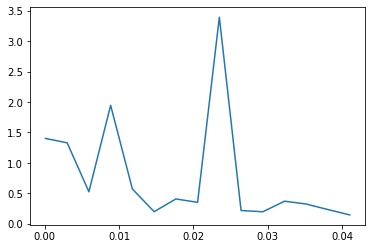

In [ ]:
plt.plot(lrs[:15], losses[:15])

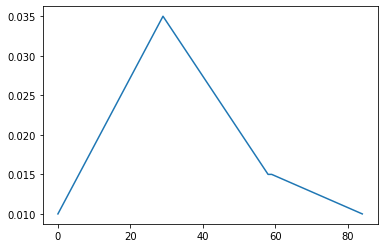

In [ ]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])
 
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [ ]:
clip = 1.0

In [ ]:
def train_model(model, lrs_triangular, epochs_number=2, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr
 
            post_processed_batch_tuple = post_process_sequence_batch(batch)
 
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            # print( "input_sequences_batch, output_sequences_batch, sequences_lengths", input_sequences_batch.shape, output_sequences_batch.shape, len(sequences_lengths))
 
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
 
            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
            # print(input_sequences_batch_var.shape)
 
            optimizer.zero_grad()
 
            logits, _ = model(input_sequences_batch_var, sequences_lengths)
            # print("output",output_sequences_batch_var.shape)
 
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()
 
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
 
            optimizer.step()
 
        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)
 
        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')
 
        val_list.append(current_val_loss)
 
        if current_val_loss < best_val_loss:
 
            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [ ]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)

Training Loss: Epoch: 0 : 0.22805845234976257
Validation Loss: Epoch: 0 : 8.319310628124921e-07

Training Loss: Epoch: 1 : 0.1033986492385698
Validation Loss: Epoch: 1 : 7.240011548704122e-07



In [ ]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

In [ ]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

In [ ]:
 rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth',map_location = torch.device("cpu")))

# validate

In [ ]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):
 
    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
 
    hidden = None
 
    for i in range(sample_length):
 
        output, hidden = rnn(current_sequence_input, [1], hidden)
 
        probabilities = nn.functional.softmax(output.div(temperature), dim=1)
 
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
 
        current_sequence_input = Variable(current_sequence_input.float())
 
        final_output_sequence.append(current_sequence_input.data.squeeze(1))
 
    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [ ]:
testset = NotesGenerationDataset('Nottingham/test/', longest_sequence_length=None)
 
testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)
 
input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
 
# input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

In [ ]:
x = input_sequences_batch_var.cpu().numpy()
plt.imshow(x.reshape((x.shape[0],88)).transpose(0,1))

In [ ]:
rnn.cuda()
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite('sample_reg_018.mid', sample.transpose(), dt=0.3)

In [ ]:
FileLink('sample_reg_018.mid')

In [ ]:
import IPython.display as ipd
ipd.Audio('./sample_reg_018.mp3')

# **EXP-1**

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self,ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.fc = nn.Linear(ninp,ninp)
        # self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        # self.decoder = nn.Linear(ninp, ntoken)

        # self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    # def init_weights(self):
    #     initrange = 0.1
    #     self.encoder.weight.data.uniform_(-initrange, initrange)
    #     self.decoder.bias.data.zero_()
    #     self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        # print("src",src.shape)
        # src = self.encoder(src) * math.sqrt(self.ninp)
        # print("src",src.shape)
        src = self.pos_encoder(src)
        # print("src",src.shape)
        output = self.transformer_encoder(src)
        # print("output",output.shape)
        output = self.fc(output)
        # print("output",output.shape)
        logits = output.transpose(0, 1).contiguous()
        # print("logits_trans",logits.shape)      
        neg_logits = (1 - logits)
        # print("neg_logits",neg_logits.shape)
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        # print("binary_logits",binary_logits.shape)
        logits_flatten = binary_logits.view(-1, 2)
        # print("logits_flatten",logits_flatten.shape)
        return logits_flatten

In [ ]:
# ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 88 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(emsize, nhead, nhid, nlayers, dropout).cuda()

In [ ]:
batch = next(iter(trainset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)
 
input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
# print("input_sequences_batch, output_sequences_batch, sequences_lengths", input_sequences_batch.shape, output_sequences_batch.shape, len(sequences_lengths))
 
# output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
output_sequences_batch_var = output_sequences_batch.permute(1,0,2).contiguous().cuda()
print(output_sequences_batch_var.shape)
input_sequences_batch_var = input_sequences_batch.cuda()
print(input_sequences_batch_var.shape)
  
logits = model(input_sequences_batch_var)
print("logits",logits.shape)

input_sequences_batch, output_sequences_batch, sequences_lengths torch.Size([320, 8, 88]) torch.Size([8, 320, 88]) 8
torch.Size([320, 8, 88])
torch.Size([320, 8, 88])
src torch.Size([320, 8, 88])
src torch.Size([320, 8, 88])
output torch.Size([320, 8, 88])
output torch.Size([320, 8, 88])
logits_trans torch.Size([8, 320, 88])
neg_logits torch.Size([8, 320, 88])
binary_logits torch.Size([8, 320, 88, 2])
logits_flatten torch.Size([225280, 2])
logits torch.Size([225280, 2])


In [ ]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1
 
            post_processed_batch_tuple = post_process_sequence_batch(batch)
 
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
 
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
 
            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
 
            optimizer.zero_grad()
 
            logits, _ = model(input_sequences_batch_var, sequences_lengths)
 
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
 
            torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
 
            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

In [ ]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

In [ ]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0
 
    for batch in valset_loader:
 
        post_processed_batch_tuple = post_process_sequence_batch(batch)
 
        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
 
        output_sequences_batch_var = output_sequences_batch.contiguous().view(-1).cuda() 
 
        input_sequences_batch_var = input_sequences_batch.cuda() 
 
        logits = model(input_sequences_batch_var, sequences_lengths)
        # print("logits",logits.shape)
 
        loss = criterion_val(logits, output_sequences_batch_var)
 
        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)
 
    return full_val_loss / (overall_sequence_length * 88)

In [ ]:
def train_model(model, lrs_triangular, epochs_number=5, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr
 
            post_processed_batch_tuple = post_process_sequence_batch(batch)
 
            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            # print( "input_sequences_batch, output_sequences_batch, sequences_lengths", input_sequences_batch.shape, output_sequences_batch.shape, len(sequences_lengths))
 
            output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
 
            input_sequences_batch_var = input_sequences_batch.cuda()
            # print(input_sequences_batch_var.shape)
 
            optimizer.zero_grad()
 
            logits = model(input_sequences_batch_var, sequences_lengths)
            # print("output",output_sequences_batch_var.shape)
 
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()
 
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
 
            optimizer.step()
 
        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)
 
        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')
 
        val_list.append(current_val_loss)
 
        if current_val_loss < best_val_loss:
 
            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [ ]:
emsize = 88 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
clip = 1.0
best_val_loss = float("inf")
model = TransformerModel(emsize, nhead, nhid, nlayers, dropout).cuda()
criterion = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(model, lrs_triangular)

Training Loss: Epoch: 0 : 0.14503519808830218
Validation Loss: Epoch: 0 : 7.517636007029678e-07

Training Loss: Epoch: 1 : 0.11493732901506645
Validation Loss: Epoch: 1 : 7.39191362876679e-07

Training Loss: Epoch: 2 : 0.11418354320664738
Validation Loss: Epoch: 2 : 7.584127456588481e-07

Training Loss: Epoch: 3 : 0.11408784058551456
Validation Loss: Epoch: 3 : 7.454765323638247e-07

Training Loss: Epoch: 4 : 0.11427047597460968
Validation Loss: Epoch: 4 : 7.44519288445025e-07



In [ ]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(model, lrs_triangular, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.11171842583043631
Validation Loss: Epoch: 0 : 6.552056531729898e-07

Training Loss: Epoch: 1 : 0.09327773567895557
Validation Loss: Epoch: 1 : 5.217086679354278e-07



In [ ]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(model, lrs_triangular, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.08663557417864023
Validation Loss: Epoch: 0 : 5.18805455603513e-07

Training Loss: Epoch: 1 : 0.08562649465924085
Validation Loss: Epoch: 1 : 5.072821968429208e-07



In [ ]:
model.load_state_dict(torch.load('music_model_padfront_regularized.pth',map_location = torch.device("cpu")))

<All keys matched successfully>

In [ ]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):
 
    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
 
    hidden = None
 
    for i in range(sample_length):
 
        output = rnn(current_sequence_input)
 
        probabilities = nn.functional.softmax(output.div(temperature), dim=1)
 
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
 
        current_sequence_input = Variable(current_sequence_input.float())
 
        final_output_sequence.append(current_sequence_input.data.squeeze(1))
 
    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

TESTING

In [ ]:
!cp /content/Nottingham/test/ashover_simple_chords_11.mid /content/test1

In [ ]:
os.rmdir('/content/test1/.ipynb_checkpoints')

In [ ]:
testset = NotesGenerationDataset('/content/test1', longest_sequence_length=None)
 
testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)
 
input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
 
# input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([160, 1, 88])

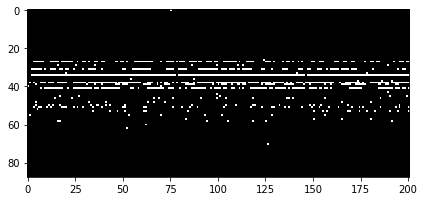

In [ ]:
model.cuda()
sample = sample_from_piano_rnn(model, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite('testing_trans.mid', sample.transpose(), dt=0.3)

In [ ]:
FileLink('testing_trans.mid')

/content/test1/testing_trans.mid

# TRANSFORMER

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("spacy"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 8.06MB/s]


extracting


In [ ]:
TEXT.build_vocab

In [ ]:
def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [ ]:
test = TransformerModel( emsize, nhead, nhid, nlayers, dropout)
test

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=88, out_features=88, bias=True)
        )
        (linear1): Linear(in_features=88, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=88, bias=True)
        (norm1): LayerNorm((88,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((88,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=88, out_features=88, bias=True)
        )
        (linear1): Linear(in_features=88, out_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.Size([35, 20, 200])
src torch.Size([35, 20])
src torch.Size([35, 20, 200])
src torch.

KeyboardInterrupt: ignored

In [ ]:
data, targets = get_batch(train_data, 0)
src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
output = model(data, src_mask)
out, out_idx = torch.max(output, 2)
#
for (pred, tar) in zip(out_idx[0].cpu().numpy().tolist(), data[0].cpu().numpy().tolist()):
    print('{}       {}'.format(TEXT.vocab.itos[pred], TEXT.vocab.itos[tar]))

<eos>        
it       so
asteroid       an
the       .
unk       <
successful       increasingly
was       tech
the       and
the       .
of       form
,       gentil
,       greene
,       book
yard       @-@
,       star
and       ,
jackson       walter
it       that
second       the
it       that


# rough

In [ ]:
x = torch.randn(2,2,2)
print(x)
y = 1 - x
print(y)

tensor([[[-0.3318, -0.0384],
         [ 0.6170,  0.4005]],

        [[ 0.7947, -0.3588],
         [ 0.7678, -0.0138]]])
tensor([[[1.3318, 1.0384],
         [0.3830, 0.5995]],

        [[0.2053, 1.3588],
         [0.2322, 1.0138]]])


In [ ]:
import torch
import torch.nn as nn
m = nn.Linear(50, 30)
input = torch.randn(128, 30,50)
output = m(input)
print(output.size())

torch.Size([128, 30, 30])
